In [1]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.my_fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2

In [2]:
# TODO: Trim the fluff from this notebook and use new pipeline for everything
#Minimally working though which is great!

In [3]:
data_file = torch.load("data/Crime/data.pt")

In [4]:
# X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
# plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [5]:
data_tot = data_file['data']
context_tot = data_file['context']
labels_tot = data_file['labels']

In [6]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data_tot, context_tot, labels_tot, test_size=0.2)
data_test, data_val, context_test, context_val, labels_test, labels_val = train_test_split(data_test, context_test, labels_test, test_size=0.5)

In [7]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Split data by label
data_0 = data_train[context_train.flatten()==0]
labels_0 = labels_train[context_train.flatten()==0]
context_0 = context_train[context_train.flatten()==0]

data_1 = data_train[context_train.flatten()==1]
labels_1 = labels_train[context_train.flatten()==1]
context_1 = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

data_0_val = data_val[context_val.flatten()==0]
labels_0_val = labels_val[context_val.flatten()==0]
context_0_val = context_val[context_val.flatten()==0]

data_1_val = data_val[context_val.flatten()==1]
labels_1_val = labels_val[context_val.flatten()==1]
context_1_val = context_val[context_val.flatten()==1]

# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)

label_0_set_val = TensorDataset(data_0_val, labels_0_val, context_0_val)
label_0_generator_val = torch.utils.data.DataLoader(label_0_set_val, **params)

label_1_set_val = TensorDataset(data_1_val, labels_1_val, context_1_val)
label_1_generator_val = torch.utils.data.DataLoader(label_1_set_val, **params)



In [8]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, context_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

data_set_test = TensorDataset(data_test, context_test)
data_generator_test = torch.utils.data.DataLoader(data_set_test, **params)

data_set_val = TensorDataset(data_val, context_val)
data_generator_val = torch.utils.data.DataLoader(data_set_val, **params)

In [9]:
data_set_labels_train = TensorDataset(data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_labels_val = TensorDataset(data_val, labels_val.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_val = torch.utils.data.DataLoader(data_set_labels_val, **params)

data_set_context_train = TensorDataset(data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_context_val = TensorDataset(data_val, context_val.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_val = torch.utils.data.DataLoader(data_set_context_val, **params)

label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train, data_generator_labels_val)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train, data_generator_context_val)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test.squeeze())
adv_acc = adversarial_classifier.accuracy(data_test, context_test.squeeze())

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", adv_acc)


 17%|█▋        | 8499/50000 [00:08<00:41, 1000.42it/s]


Early stopping reached after 17 epochs


 26%|██▌       | 12999/50000 [00:12<00:36, 1022.69it/s]

Early stopping reached after 26 epochs
Label accuracy: 0.8743718862533569 Adversarial accuracy: 0.9698492288589478


In [13]:
data_set_context_train = TensorDataset(data_train, labels_train, context_train) #For probability flow, learn distributions conditioned on context
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_val = TensorDataset(data_val, labels_val, context_val)
data_generator_val = torch.utils.data.DataLoader(data_set_val, **params)

In [14]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
                  gamma = 0.5,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [15]:
val_loss = probability_flow.fit_prob_flow(
        data_generator_context_train,
        data_generator_val,
        lr=1e-4,
        weight_decay=1e-4,
        max_num_epochs=100,
        n_steps_per_epoch=int(1e2),
        patience=10,)

 33%|███▎      | 3299/10000 [00:52<01:45, 63.36it/s]

Early stopping reached after 33 epochs


In [61]:
# n_steps_prob = 4000
# num_epochs = 5
# probability_loss = []
# best_params = probability_flow.state_dict()
# best_loss_val = np.inf

# probability_flow.train()
# for n_step in trange(n_steps_prob):
#     data, labels, context = next(iter(data_generator_context_train))
#     labels = labels.squeeze()
    
#     optimizer.zero_grad()

#     loss = probability_flow.prob_flow_loss(data, labels, context)

#     probability_loss.append(loss.item())

#     if (n_step+1) % (n_steps_prob/num_epochs) == 0:
#         print(n_step)
#         data_val, labels_val, context_val = next(iter(data_generator_val))
#         loss_val = probability_flow.prob_flow_loss(data_val, labels_val, context_val)
#         if loss_val.item() < best_loss_val:
#             best_loss_val = loss_val.item()
#             best_params = copy.deepcopy(probability_flow.state_dict())
#             print(best_loss_val)

#     loss.backward()
#     optimizer.step()
# probability_flow.eval();
# probability_flow.load_state_dict(best_params)

 20%|██        | 806/4000 [00:12<00:51, 61.66it/s]

799
-1.6978377103805542


 40%|████      | 1609/4000 [00:25<00:38, 61.51it/s]

1599
-2.1723010540008545


 60%|██████    | 2407/4000 [00:38<00:25, 62.52it/s]

2399


 80%|████████  | 3212/4000 [00:50<00:12, 65.05it/s]

3199


100%|██████████| 4000/4000 [01:02<00:00, 64.02it/s]

3999


<All keys matched successfully>

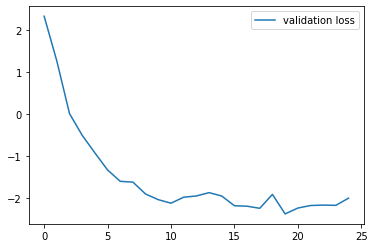

In [11]:
plt.plot(val_loss, label="validation loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

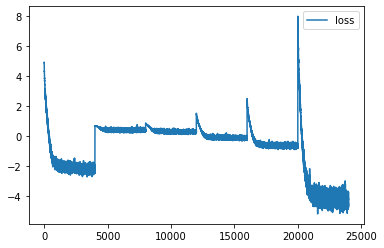

In [69]:
plt.plot(probability_loss, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [12]:
with torch.no_grad():
    embedded_data_train, _ = probability_flow._transform(data_train, context_train)
    embedded_data_val,_ = probability_flow._transform(data_val, context_val)
    embedded_data_test, _ = probability_flow._transform(data_test, context_test)
embedded_data_set_labels_train = TensorDataset(embedded_data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
embedded_data_generator_labels_train = torch.utils.data.DataLoader(embedded_data_set_labels_train, **params)

embedded_data_set_labels_val = TensorDataset(embedded_data_val, labels_val.squeeze()) #For adversairal classifier, use data and context but not labels
embedded_data_generator_labels_val = torch.utils.data.DataLoader(embedded_data_set_labels_val, **params)

embedded_data_set_context_val = TensorDataset(embedded_data_val, context_val.squeeze()) #For adversairal classifier, use data and context but not labels
embedded_data_generator_context_val = torch.utils.data.DataLoader(embedded_data_set_context_val, **params)

embedded_data_set_context_train = TensorDataset(embedded_data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
embedded_data_generator_context_train = torch.utils.data.DataLoader(embedded_data_set_context_train, **params)

In [13]:
#Get label and adversarial accuracy on embedded data (gamma = 0.5)
label_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
label_classifier.fit(embedded_data_generator_labels_train, embedded_data_generator_labels_val)

adversarial_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
adversarial_classifier.fit(embedded_data_generator_context_train, embedded_data_generator_context_val)

probability_embedded_label_acc = label_classifier.accuracy(embedded_data_test, labels_test.squeeze())
probability_adv_acc = adversarial_classifier.accuracy(embedded_data_test, context_test.squeeze())

print("P-flow Label accuracy:", probability_embedded_label_acc, "P-flow Adversarial accuracy:", probability_adv_acc)


 13%|█▎        | 6499/50000 [00:05<00:39, 1087.96it/s]


Early stopping reached after 13 epochs


 17%|█▋        | 8499/50000 [00:07<00:37, 1099.40it/s]

Early stopping reached after 17 epochs
P-flow Label accuracy: 0.7099999785423279 P-flow Adversarial accuracy: 0.6449999809265137


## Multiple $\gamma$ runs

In [14]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
prob_flows = []

In [15]:
#todo Add patience parameter instead of num_epochs
val_losses = []
for gamma in gammas:
    probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
                  gamma = gamma,
        )
    
    val_loss = probability_flow.fit_prob_flow(
        data_generator_context_train,
        data_generator_val,
        lr=1e-4,
        weight_decay=1e-4,
        max_num_epochs=100,
        n_steps_per_epoch=int(1e2),
        patience=10,)

    val_losses.append(val_loss)
    prob_flows.append(probability_flow)


 23%|██▎       | 2299/10000 [00:36<02:02, 62.79it/s]


Early stopping reached after 23 epochs


 22%|██▏       | 2199/10000 [00:35<02:04, 62.61it/s]


Early stopping reached after 22 epochs


 34%|███▍      | 3399/10000 [00:53<01:44, 63.36it/s]


Early stopping reached after 34 epochs


 22%|██▏       | 2199/10000 [00:34<02:03, 63.24it/s]


Early stopping reached after 22 epochs


 29%|██▉       | 2899/10000 [00:45<01:52, 63.06it/s]

Early stopping reached after 29 epochs


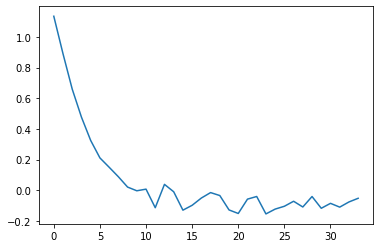

In [23]:
plt.plot(val_losses[2], label="validation loss")

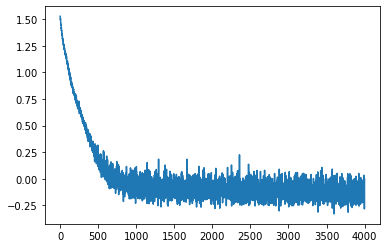

In [95]:
plt.plot(probability_loss[12000:16000])

In [25]:
label_accs = []
adv_accs = []
for prob_flow in prob_flows:

    with torch.no_grad():
        embedded_data_train, _ = prob_flow._transform(data_train, context_train)
        embedded_data_val, _ = prob_flow._transform(data_val, context_val)
        embedded_data_test, _ = prob_flow._transform(data_test, context_test)

    embedded_data_set_labels_train = TensorDataset(embedded_data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
    embedded_data_generator_labels_train = torch.utils.data.DataLoader(embedded_data_set_labels_train, **params)

    embedded_data_set_labels_val = TensorDataset(embedded_data_val, labels_val.squeeze()) 
    embedded_data_generator_labels_val = torch.utils.data.DataLoader(embedded_data_set_labels_val, **params)

    embedded_data_set_context_val = TensorDataset(embedded_data_val, context_val.squeeze())
    embedded_data_generator_context_val = torch.utils.data.DataLoader(embedded_data_set_context_val, **params)

    embedded_data_set_context_train = TensorDataset(embedded_data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
    embedded_data_generator_context_train = torch.utils.data.DataLoader(embedded_data_set_context_train, **params)

    label_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
    label_classifier.fit(embedded_data_generator_labels_train, embedded_data_set_labels_val)

    adversarial_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
    adversarial_classifier.fit(embedded_data_generator_context_train,embedded_data_set_context_val)

    probability_embedded_label_acc = label_classifier.accuracy(embedded_data_test, labels_test.squeeze())
    probability_adv_acc = adversarial_classifier.accuracy(embedded_data_test, context_test.squeeze())

    label_accs.append(probability_embedded_label_acc)
    adv_accs.append(probability_adv_acc)

  6%|▌         | 2931/50000 [00:02<00:46, 1016.91it/s]

In [ ]:
plt.plot(gammas, label_accs, label='embedded label accuracy')
plt.plot(gammas, adv_accs, label='adversarial accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*0.62, 'k-.', label='baseline high res label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.title('crime data')
# plt.savefig('prob_flow_crime_accuracy.png')
plt.show()

NameError: name 'label_accs' is not defined

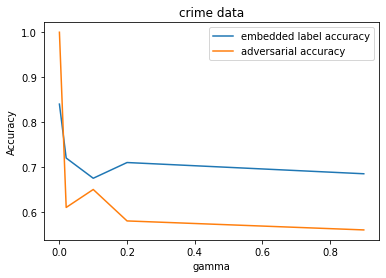

In [17]:
plt.plot(gammas, label_accs, label='embedded label accuracy')
plt.plot(gammas, adv_accs, label='adversarial accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*0.62, 'k-.', label='baseline high res label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.title('crime data')
# plt.savefig('prob_flow_crime_accuracy.png')
plt.show()

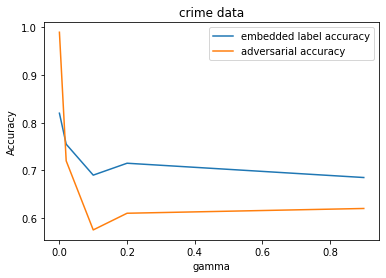

In [99]:
plt.plot(gammas, label_accs, label='embedded label accuracy')
plt.plot(gammas, adv_accs, label='adversarial accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*0.62, 'k-.', label='baseline high res label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.title('crime data')
# plt.savefig('prob_flow_crime_accuracy.png')
plt.show()

## Old

In [27]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(label_0_generator_test, label_1_generator_test,probability_func=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[1.0, 0.59375, 0.484375, 0.234375, 0.28125]


In [ ]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0_test, data_1_test, context_0=context_0_test, context_1=context_1_test, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[0.8125, 0.3203125, 0.1484375, 0.109375]


In [28]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

acc_test = EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
)

100%|██████████| 100/100 [00:04<00:00, 21.36it/s]

Training set accuracy: 0.610
Test set accuracy: 0.581


In [ ]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

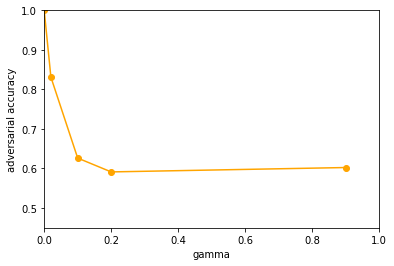

In [33]:
plt.plot(gammas, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
plt.ylabel('adversarial accuracy')
plt.show()

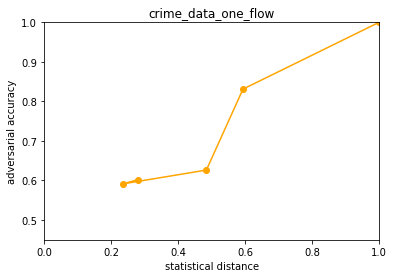

In [36]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')
plt.title('crime_data_one_flow')
plt.savefig('crime_data_one_flow.png')
plt.show()


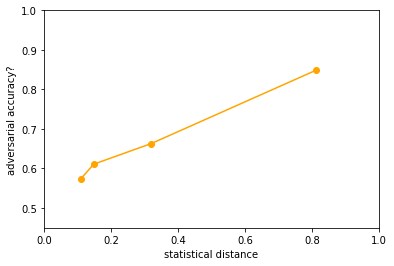

In [ ]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()

add validation set (both to probability flow and FAIR)
85, 10, 5

Check classifier accuracy (separate generation from analysis)
torch.save model
torch.load model
rewrite splitting
save probability flow separately

In [43]:
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator)
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))

100%|██████████| 10000/10000 [00:12<00:00, 823.76it/s]


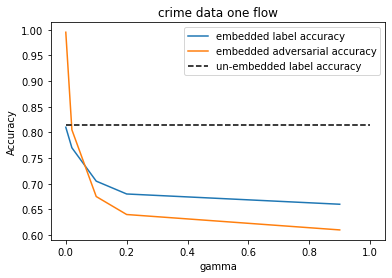

In [51]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='embedded adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='un-embedded label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title('crime data one flow')
plt.legend()
# plt.savefig('single_flow_crime_accuracy.png')
plt.show()